<a href="https://colab.research.google.com/github/michaeldlee23/cs390-project/blob/genetic-algorithm-tests/mnist-classifier/genetic_algorithm_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Statements

In [1]:
import os, random, time, imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam 
from PIL import Image
import matplotlib.pyplot as plt

plt.style.use('default')

## Constants and Configuration

In [2]:
random.seed(2187)
tf.random.set_seed(2187)

# Dataset details
IH, IW, IZ = 28, 28, 1
IMAGE_SIZE = IH * IW * IZ
NUM_CLASSES = 10

# Hyperparameters
NUM_GENERATIONS = 10
POPULATION_SIZE = 50
SELECTION_SIZE = 5
MUTATION_RATE = 0.1
MUTATION_WEIGHT_RANGE = (-1, 1)
MUTATION_BIAS_RANGE = (-0.1, 0.1)

# Toggle to continue training
CONTINUE_TRAINING = False
# CONTINUE_TRAINING = True

DRIVE_PREFIX = '/content/drive/My Drive/Colab Notebooks/genetic-algorithm-mnist/'

In [3]:
# Global lists
# Keep separate from hyperparameters so I don't accidentally reset them
currentPopulation = list()

savedMatingPool = list()  # Save the mating pool of the generation so we can continue
                          # training without having to restart
                          # Necessary because colab keeps crashing before all generations
                          # can finish for some reason
generationNum = 0

# Logging
# VERBOSE = True
VERBOSE = False
generationFitness = list()      # average fitness per generation
topGenerationFitness = list()   # average fitness of top SELECTION_SIZE individuals
                                # from each generation

## Genetic Algorithm

In [4]:
def evaluatePopulation(population, data):
  ((xTrain, yTrain), (xTest, yTest)) = data
  fitness = list()
  for i in range(len(population)):
    individual = population[i]
    predictions = predict(xTrain, individual)
    accuracy = evalResults(data[0], predictions)
    fitness.append(accuracy)
    if VERBOSE:
      print('individual %2d accuracy: %f%%' % (i + 1, accuracy * 100))
  return fitness


def crossover(parents, method='uniform'):
  print('Performing %s crossover...' % method)
  newPopulation = list()

  # Parents get to survive to next generation
  newPopulation += parents
  
  for i in range(SELECTION_SIZE, POPULATION_SIZE):
    # Select parents for new individual
    parentA, parentB = random.sample(parents, 2)

    # Construct new individual
    # Note that for this network, weights are [n x m] matrix
    # and biases are a list of size m
    individual = buildModel()
    for j in range(len(parentA.layers)):
      parentWeights = (parentA.layers[j].get_weights()[0],
                       parentB.layers[j].get_weights()[0])
      parentBiases = (parentA.layers[j].get_weights()[1],
                      parentB.layers[j].get_weights()[1])
      if method.lower() == 'uniform':
        weights, biases = uniformCrossover(parentWeights, parentBiases)
      elif method.lower() == 'spc' or 'single' in method.lower():
        weights, biases = singlePointCrossover(parentWeights, parentBiases)
      else:
        raise(ValueError('Unknown crossover method %s' % method))
        return None
      individual.layers[j].set_weights([weights, biases])
    newPopulation.append(individual)
  return newPopulation


def uniformCrossover(parentWeights, parentBiases):
  weights = np.zeros(parentWeights[0].shape)
  for r in range(weights.shape[0]):
    for c in range(weights.shape[1]):
      weights[r][c] = (parentWeights[0][r][c] if random.random() < 0.5 else
                       parentWeights[1][r][c])
      # Add random mutations
      if (random.random() < MUTATION_RATE):
        weights[r][c] += random.uniform(*MUTATION_WEIGHT_RANGE)
  biases = np.zeros(parentBiases[0].shape)
  for k in range(biases.shape[0]):
    biases[k] = (parentBiases[0][k] if random.random() < 0.5 else
                 parentBiases[1][k])
    # Add random mutations
    if (random.random() < MUTATION_RATE):
      biases[k] += random.uniform(*MUTATION_BIAS_RANGE)
  return (weights, biases)


def singlePointCrossover(parentWeights, parentBiases):
  weights = np.zeros(parentWeights[0].shape)
  weightPartition = random.randint(0, parentWeights[0].shape[0] * parentWeights[0].shape[1])
  i = 0
  for r in range(weights.shape[0]):
    for c in range(weights.shape[1]):
      if i < weightPartition:
        weights[r][c] = parentWeights[0][r][c]
      else:
        weights[r][c] = parentWeights[1][r][c]
      # Add random mutations
      if (random.random() < MUTATION_RATE):
        weights[r][c] += random.uniform(*MUTATION_WEIGHT_RANGE)
      i += 1
  biases = np.zeros(parentBiases[0].shape)
  biasPartition = weightPartition // weights.shape[0]
  for k in range(biases.shape[0]):
    if k < biasPartition:
      biases[k] = parentBiases[0][k]
    else:
      biases[k] = parentBiases[1][k]
    # Add random mutations
    if (random.random() < MUTATION_RATE):
      biases[k] += random.uniform(*MUTATION_BIAS_RANGE)
  return (weights, biases)


def evolve(population, fitness):
  global savedMatingPool
  # Order the population in order of fitness
  # Note that fitness is measured by accuracy, so we sort in descending order
  sortedIndexes = sorted(range(len(fitness)), key=lambda x: -fitness[x])
  sortedPopulation = [population[i] for i in sortedIndexes]

  print('Selected individuals: %s' % [i + 1 for i in sortedIndexes[:SELECTION_SIZE]])
  newPopulation = crossover(sortedPopulation[:SELECTION_SIZE],
                            method='uniform')
  savedMatingPool = sortedPopulation[:SELECTION_SIZE] # Save mating pool for future training
  return newPopulation


## Pipeline Functions

In [5]:
def clearOldData():
  # Clear previous runs
  global currentPopulation, generationFitness, topGenerationFitness, generationNum
  currentPopulation = list()
  generationFitness = list()
  topGenerationFitness = list()
  generationNum = 0


def getRawData():
  (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
  return ((xTrain, yTrain), (xTest, yTest))


def preprocessData(raw):
  ((xTrain, yTrain), (xTest, yTest)) = raw
  xTrain, xTest = xTrain / 255.0, xTest / 255.0
  xTrainP = xTrain.reshape((np.shape(xTrain)[0], -1))
  xTestP = xTest.reshape((np.shape(xTest)[0], -1))
  yTrainP = to_categorical(yTrain, NUM_CLASSES)
  yTestP = to_categorical(yTest, NUM_CLASSES)
  return ((xTrainP, yTrainP), (xTestP, yTestP))


def buildModel():
  model = Sequential()

  model.add(Dense(IMAGE_SIZE, input_shape=(IMAGE_SIZE, )))
  # model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


def predict(input, individual):
  prediction = individual.predict(input, 0)
  oneHot = np.zeros_like(prediction)
  oneHot[np.arange(len(prediction)), prediction.argmax(1)] = 1
  return oneHot


def getFittestIndividual(data):
  global currentPopulation, generationNum, savedMatingPool, CONTINUE_TRAINING
  if CONTINUE_TRAINING == False:
    for i in range(POPULATION_SIZE):
      currentPopulation.append(buildModel())
  else:
    # Produce new generation using saved mating pool from previous run
    # Fitness is just used to sort them, but these are already sorted
    currentPopulation = evolve(savedMatingPool,
                               np.arange(SELECTION_SIZE + 1)[SELECTION_SIZE:0:-1])

  fitness = None
  for generation in range(generationNum, generationNum + NUM_GENERATIONS):
    start = time.time()
    print('----------GENERATION %s----------' % (generation + 1))
    fitness = evaluatePopulation(currentPopulation, data)

    currentPopulation = evolve(currentPopulation, fitness)
    end = time.time()
    print('Generation produced in %ds' % (end - start))
    logFitness(sorted(fitness, reverse=True))
    generationNum += 1

  # Order the last population in order of fitness
  sortedIndexes = sorted(range(len(fitness)), key=lambda x: -fitness[x])
  sortedPopulation = [currentPopulation[i] for i in sortedIndexes]
  for i in range(SELECTION_SIZE):
    savePath = DRIVE_PREFIX + 'saved-mating-pool/parent%s' % i
    currentPopulation[i].save(savePath)
  return currentPopulation[0]


def evalResults(data, predictions):
  _, output = data
  acc = 0
  for i in range(predictions.shape[0]):
    predictedValue = np.argmax(predictions[i])
    actualValue = np.argmax(output[i])
    if np.array_equal(predictions[i], output[i]):  acc += 1
  accuracy = acc / predictions.shape[0]
  return accuracy
  

## Logging Functions

In [6]:
def logFitness(fitness):
  global generationFitness, topGenerationFitness
  averageFitness = np.mean(fitness) * 100
  averageTopFitness = np.mean(fitness[:SELECTION_SIZE]) * 100
  generationFitness.append(averageFitness)
  topGenerationFitness.append(averageTopFitness)
  print('Average accuracy of generation: %f%%' % (np.mean(fitness) * 100))
  print('     Average accuracy of top %2d: %f%%' % (SELECTION_SIZE, averageTopFitness))
  # Save these arrays
  with open(DRIVE_PREFIX + 'generationFitness.npy', 'wb') as f:
    np.save(f, generationFitness)
  with open(DRIVE_PREFIX + 'topGenerationFitness.npy', 'wb') as f:
    np.save(f, topGenerationFitness)
  

def graphFitness():
  global generationNum
  df = pd.DataFrame({'generation': [i + 1 for i in range(generationNum)],
                     'fitness': generationFitness,
                     'top': topGenerationFitness})
  OUTPUT_PATH = DRIVE_PREFIX + 'logs/learning-curve.png'
  plt.figure(figsize=(10, 10))
  plt.plot('generation', 'fitness', data=df, color='red',
           label='Population')
  plt.plot('generation', 'top', data=df, color='blue',
           label='Top %s Individuals' % SELECTION_SIZE)
  plt.grid()
  plt.xlabel('Generation')
  plt.ylabel('Average Accuracy')
  plt.title('Average Accuracy Over Time')
  plt.legend()
  plt.savefig(OUTPUT_PATH)
  print('Saved learning curve to %s' % OUTPUT_PATH)
  plt.show()
  

## Pipeline

In [7]:
# Option to load saved mating pool
def loadSavedData(modelsPath, fitPath, topFitPath):
  global generationFitness, topGenerationFitness, savedMatingPool
  savedModelPaths = [os.path.join(modelsPath, d) for d in os.listdir(modelsPath)]
  savedMatingPool = [tf.keras.models.load_model(path) for path in savedModelPaths]

  with open(fitPath, 'rb') as f:
    generationFitness = list(np.load(f))
  with open(topFitPath, 'rb') as f:
    topGenerationFitness = list(np.load(f))

CONTINUE_TRAINING = True
loadSavedData(DRIVE_PREFIX + 'saved-mating-pool',
              DRIVE_PREFIX + 'generationFitness.npy',
              DRIVE_PREFIX + 'topGenerationFitness.npy')
assert len(savedMatingPool) == SELECTION_SIZE
assert len(generationFitness) == len(topGenerationFitness)
generationNum = len(generationFitness)
print('Picking up at generation: ', generationNum + 1)

Picking up at generation:  69


Selected individuals: [1, 2, 3, 4, 5]
Performing uniform crossover...
----------GENERATION 69----------
Selected individuals: [1, 2, 14, 37, 3]
Performing uniform crossover...
Generation produced in 125s
Average accuracy of generation: 32.106833%
     Average accuracy of top  5: 38.001333%
----------GENERATION 70----------
Selected individuals: [1, 41, 2, 3, 44]
Performing uniform crossover...
Generation produced in 122s
Average accuracy of generation: 32.416467%
     Average accuracy of top  5: 38.214667%
----------GENERATION 71----------
Selected individuals: [1, 2, 3, 4, 38]
Performing uniform crossover...
Generation produced in 122s
Average accuracy of generation: 31.475300%
     Average accuracy of top  5: 38.238333%
----------GENERATION 72----------
Selected individuals: [1, 2, 3, 4, 5]
Performing uniform crossover...
Generation produced in 123s
Average accuracy of generation: 31.242833%
     Average accuracy of top  5: 38.238333%
----------GENERATION 73----------
Selected indivi

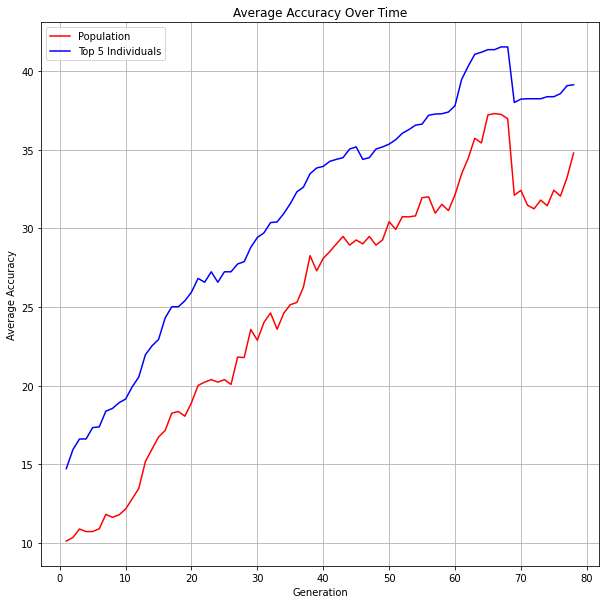

In [8]:
def main():
  global CONTINUE_TRAINING
  start = time.time()
  if CONTINUE_TRAINING == False:
    clearOldData()
  raw = getRawData()
  data = preprocessData(raw)
  model = getFittestIndividual(data)
  predictions = predict(data[1][0], model)
  accuracy = evalResults(data[1], predictions)
  end = time.time()
  print('Classifier Accuracy: %f%%' % (accuracy * 100))
  print('Finished in %ds' % (end - start))
  graphFitness()

if __name__ == "__main__":
  main()


## Testing

In [9]:
print(savedMatingPool)
print(generationFitness)
print(topGenerationFitness)
print(generationNum)

[<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa7fea7be10>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa7fe98bf60>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa7ff640630>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa7feb53128>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa838209080>]
[10.1242, 10.352999999999998, 10.893900000000002, 10.726266666666668, 10.731900000000001, 10.906366666666665, 11.821833333333332, 11.633066666666666, 11.789333333333332, 12.157566666666668, 12.812733333333334, 13.46983333333333, 15.1729, 15.963033333333332, 16.737599999999997, 17.15433333333333, 18.249266666666667, 18.363, 18.061866666666667, 18.921433333333333, 20.017799999999998, 20.227633333333333, 20.388100000000005, 20.227633333333333, 20.388100000000005, 20.078133333333337, 21.81386666666667, 21.7916, 23.578733333333332, 22.88843333333333, 24.025800000000004, 24.623, 23.59063333333